In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phanvntrng","key":"462fc0630a2c2e975ae76614ccf2ebe7"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d priyamchoksi/credit-card-transactions-dataset

Dataset URL: https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset
License(s): apache-2.0
 93% 135M/145M [00:00<00:00, 124MB/s]
100% 145M/145M [00:01<00:00, 148MB/s]


In [4]:
import zipfile
import os
with zipfile.ZipFile('credit-card-transactions-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('credit_card_data')

print(os.listdir('credit_card_data'))

['credit_card_transactions.csv']


In [56]:
import pandas as pd

data_path = 'credit_card_data/credit_card_transactions.csv'
df = pd.read_csv(data_path)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

In [58]:
df.drop(columns=['Unnamed: 0', 'first', 'last', 'street', 'merch_zipcode'], inplace=True)

# Convert `trans_date_trans_time` and `dob` to datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Feature Engineering: Extract hour, day, and month from `trans_date_trans_time`
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day
df['trans_month'] = df['trans_date_trans_time'].dt.month

# Feature Engineering: Calculate age from `dob`
current_year = pd.to_datetime('today').year
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year

# Feature Engineering: job categories
job_categories = {
    'Engineer': ['Engineer', 'Engineering', 'Civil engineer', 'Structural engineer', 'Electrical engineer', 'Mechanical engineer'],
    'Medical': ['Doctor', 'Nurse', 'Surgeon', 'Physiotherapist', 'Psychologist', 'Radiographer', 'Pharmacist'],
    'Teacher/Education': ['Teacher', 'Professor', 'Lecturer', 'Education', 'Tutor', 'Researcher', 'Counsellor'],
    'IT': ['Programmer', 'Developer', 'Data scientist', 'IT consultant', 'Systems analyst', 'Network engineer'],
    'Legal': ['Solicitor', 'Lawyer', 'Barrister', 'Legal', 'Attorney'],
    'Finance': ['Banker', 'Accountant', 'Investment', 'Financial', 'Auditor', 'Trader'],
}

def categorize_job(job_title):
    for category, keywords in job_categories.items():
        if any(keyword in job_title for keyword in keywords):
            return category
    return 'Other'

df['job_category'] = df['job'].apply(categorize_job)

df.drop(columns=['job'], inplace=True)

In [59]:
# Haversine formula to calculate distance between two points on the Earth's surface in kilometers
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    r = 6371
    return r * c

df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

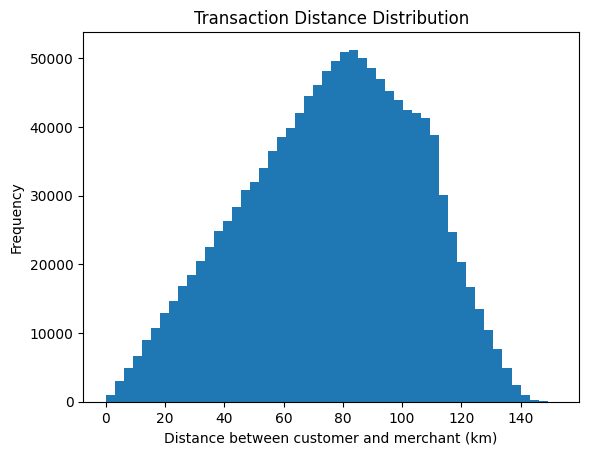

In [10]:
plt.hist(df['distance'], bins=50)
plt.xlabel('Distance between customer and merchant (km)')
plt.ylabel('Frequency')
plt.title('Transaction Distance Distribution')
plt.show()

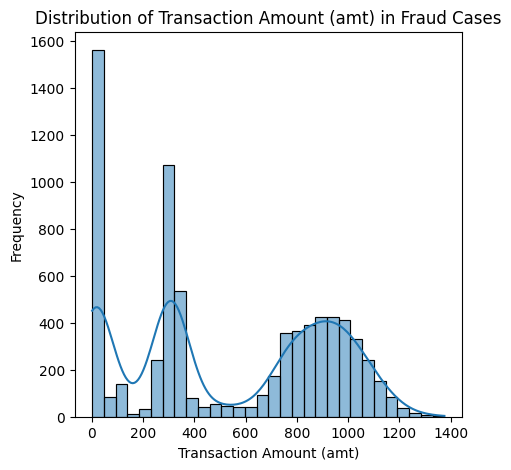

In [60]:
# Plot the distribution of 'amt' for fraud cases
fraud_df = df[df['is_fraud'] == 1]

plt.figure(figsize=(5, 5))
sns.histplot(fraud_df['amt'], bins=30, kde=True)
plt.title('Distribution of Transaction Amount (amt) in Fraud Cases')
plt.xlabel('Transaction Amount (amt)')
plt.ylabel('Frequency')
plt.show()

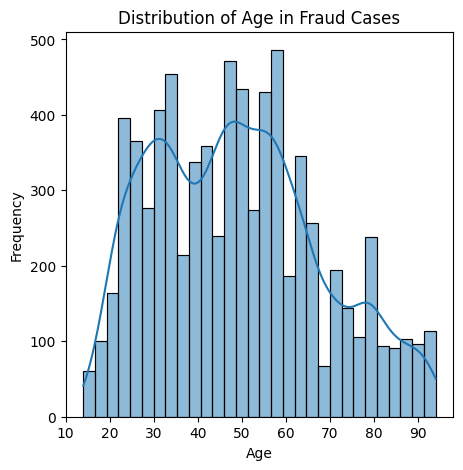

In [61]:
plt.figure(figsize=(5, 5))
sns.histplot(fraud_df['age'], bins=30, kde=True)
plt.title('Distribution of Age in Fraud Cases')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

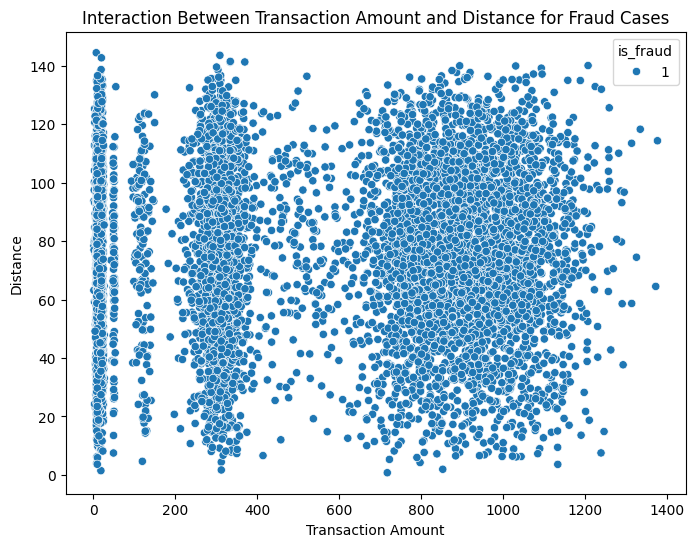

In [63]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fraud_df['amt'], y=fraud_df['distance'], hue=fraud_df['is_fraud'])
plt.title('Interaction Between Transaction Amount and Distance for Fraud Cases')
plt.xlabel('Transaction Amount')
plt.ylabel('Distance')
plt.show()
# Varied distance between clusters of transaction amount meaning low correlation with fraud

<ipython-input-39-9115edca6375>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df['is_fraud'] == 1], x='trans_hour', palette='Set1')


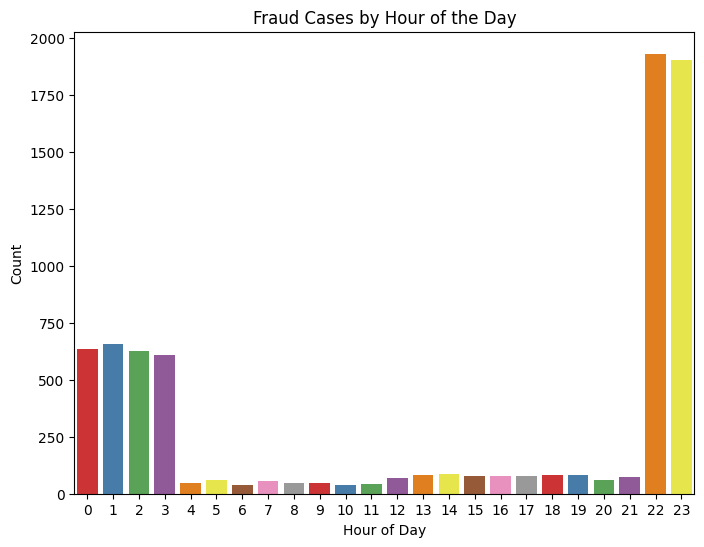

In [39]:
# Plot fraud frequency by hour
plt.figure(figsize=(8, 6))
sns.countplot(data=df[df['is_fraud'] == 1], x='trans_hour', palette='Set1')
plt.title('Fraud Cases by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()

In [11]:
# Encoding
def frequency_encoding(df, column):
    freq_encoding = df[column].value_counts() / len(df)
    df[column + '_freq'] = df[column].map(freq_encoding)
    return df

df = frequency_encoding(df, 'state')
df = frequency_encoding(df, 'category')
df = frequency_encoding(df, 'merchant')
df = frequency_encoding(df, 'job_category')
df.drop(columns=['state', 'category', 'merchant', 'job_category'], inplace=True)

In [12]:
label_enc = LabelEncoder()
df['gender'] = label_enc.fit_transform(df['gender'])

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64


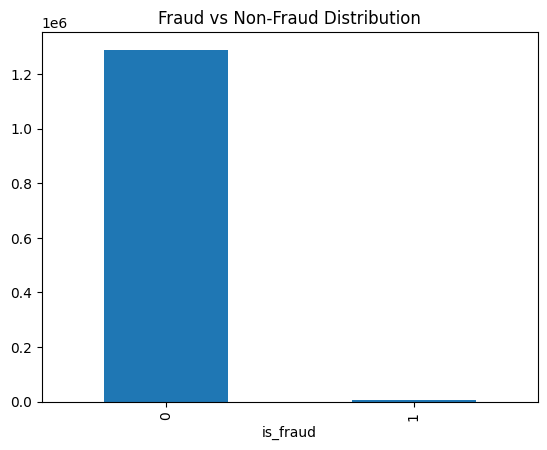

In [13]:
# Check for class imbalance in `is_fraud`
print(df['is_fraud'].value_counts(normalize=True))
df['is_fraud'].value_counts().plot(kind='bar')
plt.title('Fraud vs Non-Fraud Distribution')
plt.show()

In [14]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'amt', 'gender', 'city', 'zip',
       'lat', 'long', 'city_pop', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_hour', 'trans_day', 'trans_month',
       'age', 'distance', 'state_freq', 'category_freq', 'merchant_freq',
       'job_category_freq'],
      dtype='object')

In [15]:
# Scaling
scaler = StandardScaler()
numerical_cols = ['amt', 'city_pop', 'distance', 'age']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Split data into features (X) and target (y)
X = df.drop(columns=['is_fraud', 'trans_date_trans_time', 'dob', 'trans_num', 'cc_num', 'city', 'zip', 'lat', 'long', 'unix_time','merch_lat',
       'merch_long', 'trans_hour', 'trans_day', 'trans_month'])
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
df_cor = pd.concat([X, y], axis=1)
corr_matrix = df_cor.corr()
corr_matrix['is_fraud'].sort_values(ascending=False)

,is_fraud
is_fraud,1.000000
amt,0.219404
age,0.012453
merchant_freq,0.007968
gender,0.007642
category_freq,0.005784
city_pop,0.002136
distance,0.000403
state_freq,-0.000353
job_category_freq,-0.001630


In [17]:
# Cost-Sensitive Weighted Random Forest
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

class CostSensitiveRandomForest:
    def __init__(self, n_estimators=100, class_weight=None):
        self.n_estimators = n_estimators
        self.class_weight = class_weight
        self.forest = RandomForestClassifier(n_estimators=n_estimators, class_weight=class_weight)
        self.tree_weights = None

    def fit(self, X_train, y_train):
        self.forest.fit(X_train, y_train)
        self.tree_weights = np.zeros(self.n_estimators)
        feature_importance_sum = np.zeros(X_train.shape[1])

        # Assign weights based on misclassification cost
        for i, estimator in enumerate(self.forest.estimators_):
            y_pred_train = estimator.predict(X_train)
            cm = confusion_matrix(y_train, y_pred_train)

            FP = cm[0, 1]
            FN = cm[1, 0]
            TN = cm[0, 0]
            TP = cm[1, 1]

            minority_error = FN / (FN + TP + 1e-6)
            majority_error = FP / (FP + TN + 1e-6)
            overall_error = (FP + FN) / cm.sum()
            self.tree_weights[i] = 1 / (overall_error + 1e-6)
            if minority_error > 0:
                self.tree_weights[i] *= 1 / (minority_error + 1e-6)

            feature_importance_sum += self.tree_weights[i] * estimator.feature_importances_

        # Normalize to get the final feature importance
        self.feature_importances_ = feature_importance_sum / self.tree_weights.sum()

    def predict(self, X_test):
        tree_predictions = np.array([estimator.predict(X_test) for estimator in self.forest.estimators_])

        # Weighted majority voting
        weighted_predictions = np.zeros(X_test.shape[0])
        for i in range(self.n_estimators):
            weighted_predictions += self.tree_weights[i] * tree_predictions[i]

        # Final prediction based on majority vote of weighted predictions
        return (weighted_predictions / self.tree_weights.sum()) > 0.5

In [18]:
# Apply SMOTE + ENN
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled_2, y_resampled_2 = smote_enn.fit_resample(X_train, y_train)

In [19]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [40]:
# Training cost sensitive RF
cs_rf = CostSensitiveRandomForest(n_estimators=100, class_weight='balanced')
cs_rf.fit(X_resampled_2, y_resampled_2)
y_pred = cs_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.64      0.83      0.72      1520

    accuracy                           1.00    259335
   macro avg       0.82      0.92      0.86    259335
weighted avg       1.00      1.00      1.00    259335



In [42]:
# Random Forest feature importance
rf_feature_importance = pd.DataFrame({
    'Feature': [f'feature_{i}' for i in range(X_resampled_2.shape[1])],
    'Importance': cs_rf.feature_importances_
})

important_features_rf = rf_feature_importance[rf_feature_importance['Importance'] > 0.01]['Feature'].values
X_train_filtered_rf = X_resampled_2.iloc[:, (rf_feature_importance['Importance'] > 0.01).values]
X_test_filtered_rf = X_test.iloc[:, (rf_feature_importance['Importance'] > 0.01).values]

# Retrain Random Forest on important features
rf_model_filtered = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model_filtered.fit(X_train_filtered_rf, y_resampled_2)

y_pred_filtered_rf = rf_model_filtered.predict(X_test_filtered_rf)
print("Random Forest with Filtered Features Classification Report:")
print(classification_report(y_test, y_pred_filtered_rf))

Random Forest with Filtered Features Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.63      0.85      0.72      1520

    accuracy                           1.00    259335
   macro avg       0.81      0.92      0.86    259335
weighted avg       1.00      1.00      1.00    259335



In [44]:
# Train a normal Random Forest (no class weighting)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_resampled_2, y_resampled_2)
y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.63      0.83      0.72      1520

    accuracy                           1.00    259335
   macro avg       0.82      0.92      0.86    259335
weighted avg       1.00      1.00      1.00    259335



In [45]:
# XGboost
import xgboost as xgb
neg, pos = np.bincount(y_resampled_2)
scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_resampled_2, y_resampled_2)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.53      0.86      0.66      1520

    accuracy                           0.99    259335
   macro avg       0.77      0.93      0.83    259335
weighted avg       1.00      0.99      1.00    259335



In [46]:
# XGboost Retrain
xgb_feature_importance = pd.DataFrame({
    'Feature': [f'feature_{i}' for i in range(X_train.shape[1])],
    'Importance': xgb_model.feature_importances_
})
xgb_feature_importance = xgb_feature_importance.sort_values(by='Importance', ascending=False)

important_features_xgb = xgb_feature_importance[xgb_feature_importance['Importance'] > 0.01]['Feature'].values
X_train_filtered_xgb = X_resampled_2.iloc[:, (xgb_feature_importance['Importance'] > 0.01).values]
X_test_filtered_xgb = X_test.iloc[:, (xgb_feature_importance['Importance'] > 0.01).values]

xgb_model_filtered = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model_filtered.fit(X_train_filtered_xgb, y_resampled_2)

y_pred_filtered_xgb = xgb_model_filtered.predict(X_test_filtered_xgb)
print("XGBoost with Filtered Features Classification Report:")
print(classification_report(y_test, y_pred_filtered_xgb))

XGBoost with Filtered Features Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.52      0.87      0.65      1520

    accuracy                           0.99    259335
   macro avg       0.76      0.93      0.82    259335
weighted avg       1.00      0.99      1.00    259335



In [47]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_resampled_2, y_resampled_2)
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_resampled_2.columns,
    'Importance': lr_model.coef_[0]
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    257815
           1       0.08      0.78      0.14      1520

    accuracy                           0.94    259335
   macro avg       0.54      0.86      0.56    259335
weighted avg       0.99      0.94      0.97    259335

             Feature  Importance
6      category_freq   11.888093
0                amt    1.292573
7      merchant_freq    0.241241
3                age    0.086246
8  job_category_freq    0.030790
2           city_pop   -0.003755
4           distance   -0.016186
1             gender   -0.097956
5         state_freq   -0.973991


In [48]:
# Decision Tree with bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
base_estimator = DecisionTreeClassifier(class_weight='balanced')

bagging_cost_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
bagging_cost_model.fit(X_resampled_2, y_resampled_2)

y_pred_bagging = bagging_cost_model.predict(X_test)
print(classification_report(y_test, y_pred_bagging))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.57      0.84      0.68      1520

    accuracy                           1.00    259335
   macro avg       0.78      0.92      0.84    259335
weighted avg       1.00      1.00      1.00    259335



In [49]:
# Decision Tree with AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(max_depth=2, class_weight='balanced')

ada_cost_model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
ada_cost_model.fit(X_resampled_2, y_resampled_2)

y_pred_ada = ada_cost_model.predict(X_test)
print(classification_report(y_test, y_pred_ada))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    257815
           1       0.34      0.85      0.49      1520

    accuracy                           0.99    259335
   macro avg       0.67      0.92      0.74    259335
weighted avg       1.00      0.99      0.99    259335



In [50]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
import pandas as pd

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    metrics = {
        'Train F1-score': f1_score(y_train, y_train_pred),
        'Test F1-score': f1_score(y_test, y_test_pred),
        'Overfitting': (f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) > 0.05,
        'ROC Area': roc_auc_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1-score': f1_score(y_test, y_test_pred),
        'Support': len(y_test)
    }

    return metrics

In [54]:
# Collect all metrics into a list
cs_rf_metrics = evaluate_model(rf_model_filtered, X_train_filtered_rf, y_resampled_2, X_test_filtered_rf, y_test)
xgb_metrics = evaluate_model(xgb_model_filtered, X_train_filtered_xgb, y_resampled_2, X_test_filtered_xgb, y_test)
lr_metrics = evaluate_model(lr_model, X_resampled_2, y_resampled_2, X_test, y_test)
bagging_metrics = evaluate_model(bagging_cost_model, X_resampled_2, y_resampled_2, X_test, y_test)
adaboost_metrics = evaluate_model(ada_cost_model, X_resampled_2, y_resampled_2, X_test, y_test)
rf_metrics = evaluate_model(rf_model, X_resampled_2, y_resampled_2, X_test, y_test)

model_metrics = [cs_rf_metrics, xgb_metrics, lr_metrics, bagging_metrics, adaboost_metrics, rf_metrics]
model_labels = ['Cost-Sensitive RF', 'XGBoost', 'Logistic Regression', 'Bagging', 'AdaBoost', 'RF']

In [55]:
compare_df = pd.DataFrame(model_metrics, index=model_labels)
compare_df_sorted = compare_df.sort_values(by=['Recall'], ascending=[False])
compare_df_sorted

,Train F1-score,Test F1-score,Overfitting,ROC Area,Precision,Recall,F1-score,Support
XGBoost,0.996297,0.651437,True,0.933808,0.519796,0.872368,0.651437,259335
AdaBoost,0.987126,0.488228,True,0.921481,0.342043,0.852632,0.488228,259335
Cost-Sensitive RF,1.000000,0.719955,True,0.922191,0.625850,0.847368,0.719955,259335
Bagging,0.999989,0.679446,True,0.917875,0.570662,0.839474,0.679446,259335
RF,1.000000,0.719886,True,0.915355,0.633500,0.833553,0.719886,259335
Logistic Regression,0.840756,0.139310,True,0.860843,0.076514,0.776974,0.139310,259335
